In [13]:
# Run this line below into the console while in the directory of where the images will be saved.

# ffmpeg -start_number 0 -framerate 60 -i graph%01d.png video.webm

In this notebook we want to lookd a few different numerical wave phenomenon. I just think waves are cool and PDEs are some of my favorite structures in all of mathematics. That being said, I ultimately want to make some wave simulations under a few different constraints. My big goals are as follows:
- Create a basic 2D wave progpogation simulation
- Create a similar sort of equation for Schrodinger equation
- Create a 3D wave simulation

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from tqdm import tqdm

In [15]:
#We have this cell here to call the dataAnalysisLibrary module from one place rather than copy pasting into many other places
# the ../ means one directory back, which is, so this should fix pathing problems moving forward


sys.path.insert(0,'../Code/')
import simulationLibrary as sim

In [16]:
sim.clearDirectory()

# Basic Wave Simulation

To remind ourselves, the basic wave equation is $\frac{\partial^2 u}{\partial t^2}=c^2\nabla^2 u$. This is the generalized wave equation for multiple dimensions, for a 2d eq we simply need to reduce it down to break down that laplacian operator and we will get the simple wave equation $\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$. Why the partials, you might ask? Well that is because out position function, $u$, is a function of two variables, namely position and time. That is, $u$ is secretly $u(x,t)$ under the hood. When $t=0$ then we $u$ becomes $u(x,0)$, or, more compactly, just $u(x)$. THIS is just a curve! A 2D curve, specifically. A cross section of the wave at a certain time, specifically at our starting time $t=0$. If we advance time to anything else, then the wave should also change (It doesnt have to change, but the purposes of modeling a physical system it probably should, so moving forward we should be expecting this sort of thing). So, thus $u(x,t)$ is a function of curves, varied by space and time, that contains all the information of the wave that we want to get. That is why we are dealing with partial derivatives here. And since we are dealing with partial derivatives, how can we actually turn this into a numerical scheme that we can computer on a computer?

This question takes us to the realm of numerical analysis. Numerical analysis' entire existence is based upon approximating smooth curves and other sort of numerical algorithms. What do I mean by "numerical algorithms" or just "numerical" in general? Well, as with all words, it depends on the context. In a mathematical sense, numerical means approximation. So if you hear the term "Numerical methods" you can replace it in your mind with "approximate methods". This field is required for things that have no analytical solution, that is something that cant be explicitly solved with pen an paper. Mostly everything in nonanalytical so numerical methods are everywhere. We will be using a few things from numerical methods in this. The first thing is to find out how to represent our wave equation in a way that our computer can process. We can do this using finite difference methods for partial derivatives. Ignoring the derivation of it and going off a "trust me" sort of thing, this is the finite difference approximation for a second order partial derivative. Let $u(x,t)$ be our mutlivariate function and lets approximate it at a specific point, that is at $x_0$ and $t_0$

$$
\frac{\partial^2 u}{\partial x^2}(x_0,t_0) \approx \frac{u(x_0+\Delta x,t_0)-2u(x_0,t_0)+f(x_0-\Delta x,t_0)}{(\Delta x)^2}.
$$

This is nice, but unfortunately the field of partial differential calculus loves to use many different forms of notation for the same thing. Because of this we are gonna have to use some other notation that im not entirely fond of due to its non-ituitiveness, but alas here we are! Anyways, the notation is this:

$$
u^{(m)}_j=\tilde{u}(x_j,t_m)
$$

Where $\tilde{u}$ is the approximation of $u$ at time $t_m$ and position $x_j$. You know what? Looking back at this notation, its not that bad. I still have some problems with it, but I may have been a little hasty in my analysis of it. The approximation in this case is the central finite difference approximation that was stated up above. Using this notation, lets refine our central finite difference notation and clean up our equations a little bit using this new notation.

*********NOW INTRODUCTING A NEW NOTATION*********

We are going to derive a difference-equation method to compute approximations $\{u_{i,j}:i=1,2,...,n\}$ in successive rows for $j=2,3,...,m$

Replacing the double derivatives in the original wave equation with these new approximations gives us

$$
\frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{k^2}=c^2\frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{h^2}
$$

And, for ease, lets say $r=\frac{ck}{h}$, then our equation simplifies down to

$$
u_{i,j+1}-2u_{i,j}+u_{i,j-1}=r^2(u_{i+1,j}-2u_{i,j}+u_{i-1,j})
$$

Now solve for $u_{i,j+1}$

$$
u_{i,j+1}=(2-2r^2)u_{i,j}+r^2(u_{i+1,j}+u_{i-1,j})-u_{i,j-1}
$$

We will start at the bottom row, where $t=t_1=0$ and the solution is known to be $u(x_i,t_1)=u(x_i,0)=f(x_i)$ (aka its the initial condition). So, the true solution value at the mesh points of our grid is $u(x_i,t_j)$

In [17]:
def func(x):
    return(x*(1-x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 2150.22it/s]


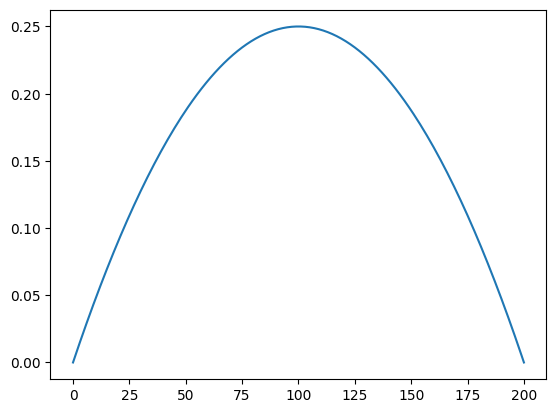

In [24]:
L=1 # Length
c=np.sqrt(9) # Wave velocity
f=5 # frequency of the input wave

totalTime = 4 # End time for the simulation
dx=0.005 # Space step size
dt=0.005 # Time step size
r=(c*dt/dx)**2 # Simplified Coefficient

# Solution Matrix Created
numberColumns = int(np.ceil(L/dx)+1) # Discretized position
numberRows = int(np.ceil(totalTime/dt)+1) # Discretized Time
u=np.zeros((int(numberRows), int(numberColumns))) # Initializing the solution matrix (each row is a different step in time)

xArray = np.linspace(0,1,numberColumns)
func(xArray)

# # Enforce Boundary Conditions
# for i in range(numberRows):
#     u[i][0] = i*(totalTime/numberRows) # Left boundary condition
#     u[i][-1] = 0 # Right boundary condition

# Enforce Boundary Conditions
for i in range(numberRows):
    u[i][0] = 0 # Left boundary condition
    u[i][-1] = 0 # Right boundary condition


# # Enforce Initial Conditions
# u[0][:]=0 # First initial confition
# for j in range(1,numberColumns-1):
#     u[1][j]=u[0][j]+(1/2)*r*(u[0][j+1]-2*u[0][j]+u[0,j-1]) # Solution for the first time step

# Enforce Initial Conditions
u[0]=func(xArray) # First initial confition
plt.plot(u[0])
for j in range(1,numberColumns-1):
    u[1][j]=u[0][j]+(1/2)*r*(u[0][j+1]-2*u[0][j]+u[0,j-1]) # Solution for the first time step

plt.plot(u[0])
plt.plot(


# Run the simulation
for i in tqdm(range(numberRows-1)):
    for j in range(numberColumns-1):
        u[i][j]=2*u[i-1,j]-u[i-2,j]+r*(u[i-1,j+1]-2*u[i-1,j]+u[i-1,j-1])

In [23]:
for i in tqdm(range(numberRows)):
    plt.plot(u[i])
    plt.xlim(0,200)
    plt.ylim(-5,5)
    plt.savefig('../..//Physics-Simulations/Images for simulation/graph'+str(i)+'.png') # dpi argument increases resolution
    plt.close('all')

 25%|██████████████████████████████████████████▍                                                                                                                                | 199/801 [00:13<00:40, 14.73it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

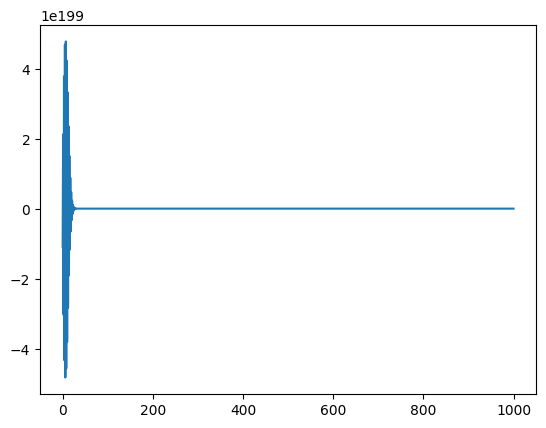

In [9]:
plt.plot(u[100])

# Schrodinger Eq

# 3D Waves